In [ ]:
%%capture
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
This file is designed to compare the Hessian calculated by the MOFD and a library-based approach during training for fitting a 1D exponential.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""

In [ ]:
%%capture
%%bash 
pip install torchdiffeq

In [ ]:
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
System set up.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

parser = argparse.ArgumentParser()
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=20)
parser.add_argument('--niters', type=int, default=100)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
parser.add_argument('--manual_hessian', action='store_true')
parser.add_argument('--library_hessian', action='store_true')
parser.add_argument('--mofd_hessian', action='store_true')
parser.add_argument('--hessian_freq', type=int, default=20)
args = parser.parse_args(args=[])

args.batch_size = 10
args.batch_time = 10
args.niters=12000
args.test_freq=100
args.hessian_freq = 100
args.library_hessian = True
args.mofd_hessian = True
args.viz = True
args.method = 'dopri5'

adjoint = False

if adjoint == True:
    from torchdiffeq import odeint_adjoint as odeint
if adjoint == False:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

true_y0 = torch.tensor([2.]).to(device)
t_0, t_1 = 0., 2.
t = torch.linspace(t_0, t_1, args.data_size).to(device)

In [ ]:
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Obtain information about the true solution to the equation of motion.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""
class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.exp(t)

#True solution defines an exponential.
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method=args.method)

def get_batch():

    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False)) 
    batch_y0 = true_y[s]  # (M, D) 
    batch_t = t[:args.batch_time]  # (T)      
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [ ]:
def visualize(true_y, pred_y, odefunc, itr):

  """
  This slightly altered version of the function visualize() seems to work fine. The only change is that I have moved the plt.figure() part of the code
  inside the function itself, i.e. I am creating a new figure environment for every figure, instead of editing the same environment multiple times.
  """

  if args.viz:

    fig = plt.figure(figsize=(12, 4), facecolor='white')  #facecolor is the background colour.
    plt.plot(t.cpu().numpy(), true_y.cpu().numpy(), 'g-', label='True_y')
    plt.plot(t.cpu().numpy(), pred_y.cpu().detach().numpy(), 'b--', label='Predicted y')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    
    #plt.savefig('png/{:03d}'.format(itr))
    plt.draw()
    plt.pause(0.001)
    plt.close()

In [ ]:
class ODEFunc(nn.Module):
    """
    Defines a neural net to parametrize the derivative of the hidden state in the NODE.
    """

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 1),
            nn.Tanh(),
            nn.Linear(1, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

func = ODEFunc().to(device)

In [ ]:
class Network(nn.Module):
  """
  Neural network that is used for Hessian calculation with library-function and MOFD approaches.
  The parameter groups are chosen to match those of ODEFunc().
  """

  def __init__(self, a, b, c, d):
    super(Network, self).__init__()
    self.a = a
    self.b = b
    self.c = c
    self.d = d

  def forward(self, t, y):
    x = F.linear(y, self.a, self.b)
    m = nn.Tanh()
    x = m(x)
    x = F.linear(x, self.c, self.d)
    return x

In [ ]:
def get_loss(params_vector):

  a = params_vector[:1].reshape([1, 1])
  b = params_vector[1:2].reshape([1])
  c = params_vector[2:3].reshape([1, 1])
  d = params_vector[3:4].reshape([1])
  
  neural_net = Network(a, b, c, d).to(device)
  pred_y = odeint(neural_net, true_y0, t, method= args.method)
  loss = torch.mean(torch.abs(pred_y - true_y))
  return loss

def get_library_hessian(net):
  """
  Obtains the Hessian of the NODE using the autograd.functional.hessian() function.
  Inputs: 
        - net: the network for which the Hessian is to be calculated.
  NB: Each individual NODE architecture must be specified in the function get_loss(), such that
  the Hessian is calculated correctly.
  """

  param_tensors = net.parameters()
  params_vector = torch.tensor([]).to(device)
  for param in param_tensors:
    vec = torch.reshape(param, (-1,)).to(device)
    params_vector = torch.cat((params_vector, vec))

  hessian = torch.autograd.functional.hessian(get_loss, params_vector)
  return hessian

In [ ]:
def get_mofd_hessian(p_vec, shapes, base_loss, h=1e-4, show_iters=False):
  """
  Calculates the full Hessian using the MOFD.
  Inputs: - p_vec: the parameters of the network organized into a vector.
          - shapes: a list of torch.Size() objects describing the shapes of each parameter group.
          - base_loss: loss of the unperturbed system. Used in calculating diagonal Hessian elements.
          - h: the size of the pertubation applied to each parameter.
          - show_iters: True or False according to whether the iteration number is to be displayed during calculation.

  NB: This function adapts to network architecture automatically.

  This code is designed to convert all floats to 64-bit automatically.
  """
  #List of integers detailing the number of elements in each parameter group.
  nels = [int(torch.prod(torch.tensor(shape))) for shape in shapes]
  nels = torch.tensor(nels)
  nels = torch.cumsum(nels, dim=0)
  nels = nels.tolist()

  #Empty tensors to store mofd info and perturbed parameters.
  up_pert_p_vec = torch.zeros_like(p_vec).double()
  low_pert_p_vec = torch.zeros_like(p_vec).double()

  up_up_pert_p_vec = torch.zeros_like(p_vec).double()
  up_low_pert_p_vec = torch.zeros_like(p_vec).double()
  low_up_pert_p_vec = torch.zeros_like(p_vec).double()
  low_low_pert_p_vec = torch.zeros_like(p_vec).double()

  w = len(p_vec)
  hessian = torch.zeros((w,w)).double()

  #The number of iterations required to compute a triangular block.
  counter = int(w*(w+1)/2)

  for i in range(len(p_vec)):
    
    #Versions of the parameter vector to be perturbed.
    for j in range(len(p_vec)):
      up_pert_p_vec[j] = p_vec[j]
      low_pert_p_vec[j] = p_vec[j]

    for k in range(len(p_vec)):
      
      #Calculate the diagonal elements.
      if k == i:
        up_pert_p_vec[k] += h
        low_pert_p_vec[k] -= h

        a_up = up_pert_p_vec[:nels[0]].reshape(shapes[0])
        b_up = up_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
        c_up = up_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
        d_up = up_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

        a_low = low_pert_p_vec[:nels[0]].reshape(shapes[0])
        b_low = low_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
        c_low = low_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
        d_low = low_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

        neural_net_up = Network(a_up, b_up, c_up, d_up).to(device)
        pred_y_up = odeint(neural_net_up, true_y0.double(), t.double(), method=args.method)
        pert_loss_up = torch.mean(torch.abs(pred_y_up - true_y.double())).double()

        neural_net_low = Network(a_low, b_low, c_low, d_low).to(device)
        pred_y_low = odeint(neural_net_low, true_y0.double(), t.double(), method=args.method)
        pert_loss_low = torch.mean(torch.abs(pred_y_low - true_y.double())).double()
        
        grad2 = ((pert_loss_up - 2*base_loss + pert_loss_low)/(h**2)).double()
        hessian[k,k] = grad2

        if show_iters:
          counter -=1
          print('\r' + str(counter) + ' iterations remaining.', end = '')

      #Calculate the off-diagonal elements.
      if k > i:
        
        #Vectors to be perturbed (there are 4 of these).
        #They must be created individually for each k so that previous iterations do not affect the parameter values.
        for l in range(len(p_vec)):
          up_up_pert_p_vec[l] = p_vec[l]
          up_low_pert_p_vec[l] = p_vec[l]
          low_up_pert_p_vec[l] = p_vec[l]
          low_low_pert_p_vec[l] = p_vec[l]

        up_up_pert_p_vec[i] += h
        up_up_pert_p_vec[k] += h

        up_low_pert_p_vec[i] += h
        up_low_pert_p_vec[k] -= h

        low_up_pert_p_vec[i] -= h
        low_up_pert_p_vec[k] += h

        low_low_pert_p_vec[i] -= h
        low_low_pert_p_vec[k] -= h

        a_up_up = up_up_pert_p_vec[:nels[0]].reshape(shapes[0])
        b_up_up = up_up_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
        c_up_up = up_up_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
        d_up_up = up_up_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

        a_up_low = up_low_pert_p_vec[:nels[0]].reshape(shapes[0])
        b_up_low = up_low_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
        c_up_low = up_low_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
        d_up_low = up_low_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

        a_low_up = low_up_pert_p_vec[:nels[0]].reshape(shapes[0])
        b_low_up = low_up_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
        c_low_up = low_up_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
        d_low_up = low_up_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

        a_low_low = low_low_pert_p_vec[:nels[0]].reshape(shapes[0])
        b_low_low = low_low_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
        c_low_low = low_low_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
        d_low_low = low_low_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

        neural_net_up_up = Network(a_up_up, b_up_up, c_up_up, d_up_up).to(device)
        pred_y_up_up = odeint(neural_net_up_up, true_y0.double(), t.double(), method=args.method)
        pert_loss_up_up = torch.mean(torch.abs(pred_y_up_up - true_y.double())).double()

        neural_net_up_low = Network(a_up_low, b_up_low, c_up_low, d_up_low).to(device)
        pred_y_up_low = odeint(neural_net_up_low, true_y0.double(), t.double(), method=args.method)
        pert_loss_up_low = torch.mean(torch.abs(pred_y_up_low - true_y.double())).double()

        neural_net_low_up = Network(a_low_up, b_low_up, c_low_up, d_low_up).to(device)
        pred_y_low_up = odeint(neural_net_low_up, true_y0.double(), t.double(), method=args.method)
        pert_loss_low_up = torch.mean(torch.abs(pred_y_low_up - true_y.double())).double()

        neural_net_low_low = Network(a_low_low, b_low_low, c_low_low, d_low_low).to(device)
        pred_y_low_low = odeint(neural_net_low_low, true_y0.double(), t.double(), method=args.method)
        pert_loss_low_low = torch.mean(torch.abs(pred_y_low_low - true_y.double())).double()
        
        #MOFD formula to estimate second order gradient.
        grad2 = ((pert_loss_up_up - pert_loss_up_low - pert_loss_low_up + pert_loss_low_low)/(4*h**2)).double()
        hessian[i,k] = grad2
        hessian[k,i] = grad2

        if show_iters:
          counter -=1
          print('\r' + str(counter) + ' iterations remaining.', end='')

      else:
        pass

  return hessian

In [ ]:
def get_manual_hessian(grads, parameters):
  """
  Calculation of the Hessian using nested for loops.
  Inputs: 
    grads:      tuple of gradient tensors. Created using something like grads = torch.autograd.grad(loss, parameters, create_graph=True).
    parameters: list of parameter objects. Created using something like parameters = optimizer.param_groups[0]['params'].
  """
  start = time.time()                       #Begin timer.

  n_params = 0
  for param in parameters:
    n_params += torch.numel(param)
  grads2 = torch.zeros(n_params,n_params)             #Create an matrix of zeros thas has the same shape as the Hessian.

  y_counter = 0                             #y_direction refers to row number in the Hessian.

  for grad in grads:
      grad = torch.reshape(grad, [-1])                                  #Rearrange the gradient information into a vector.        

      for j, g in enumerate(grad):
        x_counter = 0                                                   #x_direction refers to column number in the Hessian.

        for l, param in enumerate(parameters):
          g2 = torch.autograd.grad(g, param, retain_graph=True)[0]      #Calculate the gradient of an element of the gradient wrt one layer's parameters.
          g2 = torch.reshape(g2, [-1])                                  #Reshape this into a vector.
          len = g2.shape[0]                       
          grads2[j+y_counter, x_counter:x_counter+len] = g2             #Indexing ensures that the second order derivatives are placed in the correct positions.
          x_counter += len

      grads2 = grads2.to(device)
      y_counter += grad.shape[0]
      print("Gradients calculated for row number " + str(y_counter) + ".")
  
  print('Time used was ', time.time() - start)

  return grads2

In [1]:

if __name__ == '__main__':
    """
    Executes the programme. This includes doing the following:

      - Trains the network;
      - Outputs the results in a series of png files (if desired);
      - Outputs hessian matrix information in list form.
    """

    ii = 0

    func = ODEFunc().to(device)
    
    optimizer = optim.RMSprop(func.parameters(), lr=1e-3) #func.parameters are the parameters to optimise.

    #Lists in which to store hessian data.
    #These will be lists of tuples like (iteration number, time, loss, hessian data).
    library_hessian_data = []
    loss_data = []

    for itr in range(1, args.niters + 1):
        optimizer.zero_grad()                                 
        batch_y0, batch_t, batch_y = get_batch()           
        pred_y = odeint(func, batch_y0, batch_t, method = args.method)
        loss = torch.mean(torch.abs(pred_y - batch_y))        
        loss.backward(create_graph=True)  

        if itr % args.hessian_freq == 0 or itr==1:

          if args.library_hessian:
              print('\n---------------------------------------------')
              print('Obtaining library hessian...')
              library_start = time.time()
              library_hessian = get_library_hessian(func)                       #get hessian with library functions   
              library_end = time.time()
              print("Time taken for library-based approach was " + str(round(library_end-library_start,2)) + "s.")
              library_hessian_data.append((itr, library_end-library_start, loss.item(), library_hessian)) 

              torch.save(func,    '/content/drive/MyDrive/colab_notebooks/calculating_hessians/mofd_hessian'
                                + '/exponential_curve_with_mofd/experiment_3/models/model_' 
                                +  str(itr) + '.pt' )                                                                  
      
        if itr % args.test_freq == 0:
          ii += 1       
          with torch.no_grad():
              pred_y = odeint(func, true_y0, t, method= args.method)
              loss = torch.mean(torch.abs(pred_y - true_y))
              loss_data.append((itr, loss.item()))
              print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
              visualize(true_y, pred_y, func, ii)

        optimizer.step()
        print('\rIteration Number: ' + str(itr), end='') 

NameError: ignored

In [2]:
torch.save(library_hessian_data, '/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_simple_nodes/sinusoidal_curve/'
                                + 'library_hessian_data.pt')

torch.save(loss_data, '/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_simple_nodes/sinusoidal_curve/'
                                + 'loss_data.pt')

NameError: ignored

In [ ]:
#Create and save a loss curve.

itrs = []
data = []

for item in loss_data:
  itrs.append(item[0])
  data.append(item[1])

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 14})
plt.plot(itrs, data)
plt.title('Loss function for ' + str(args.method) + ' solver\nBatch Size, Time = ' + str(args.batch_size) + ', ' + str(args.batch_time) )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('/content/drive/MyDrive/colab_notebooks/calculating_hessians/mofd_hessian'
              '/exponential_curve_with_mofd/experiment_3/loss_curve_.png')
plt.show()

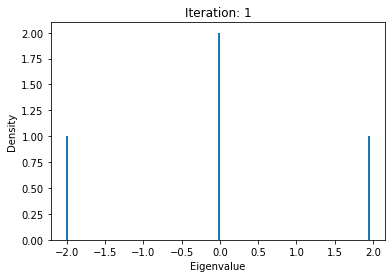

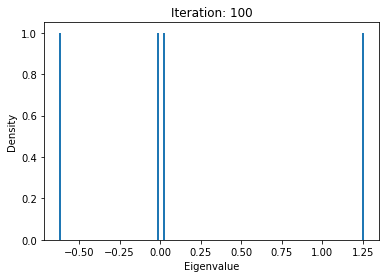

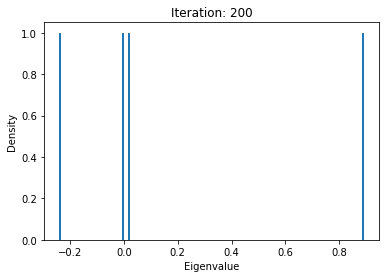

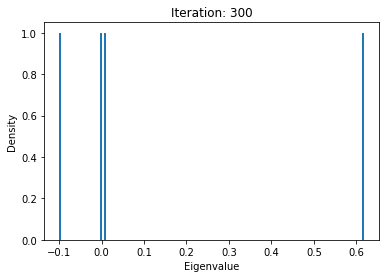

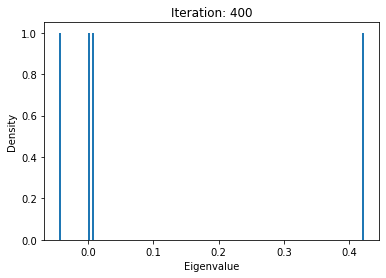

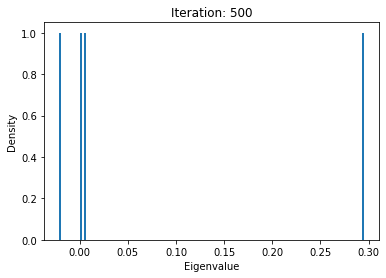

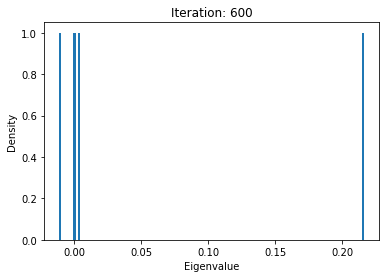

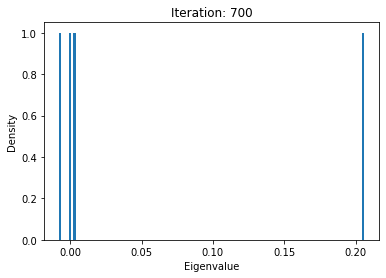

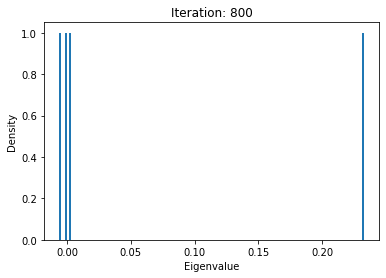

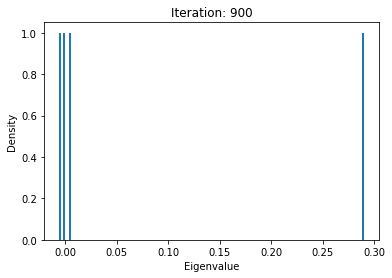

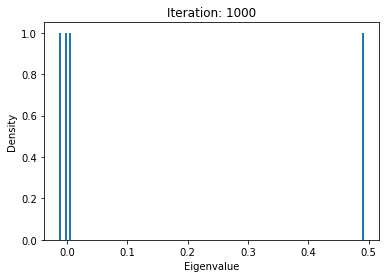

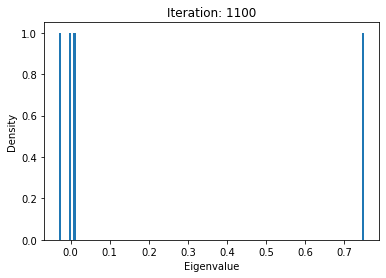

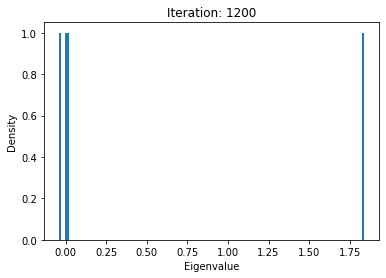

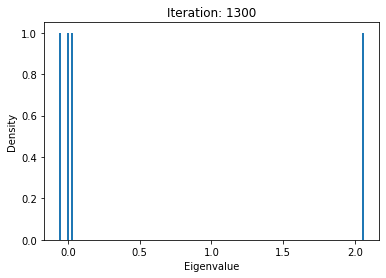

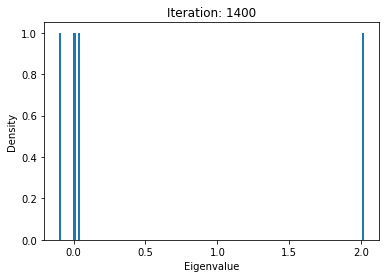

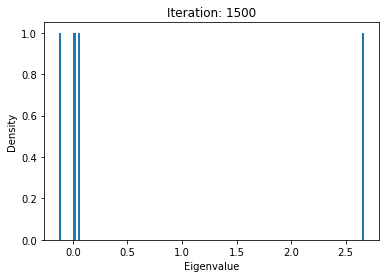

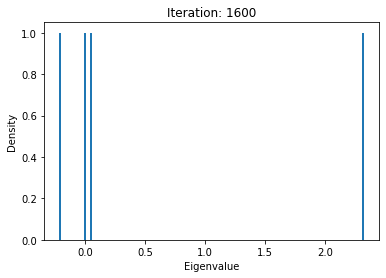

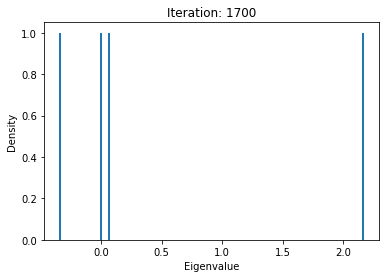

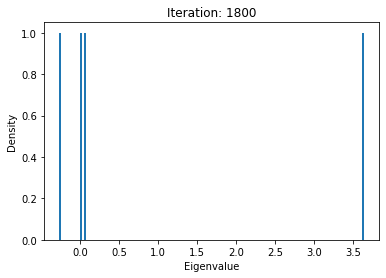

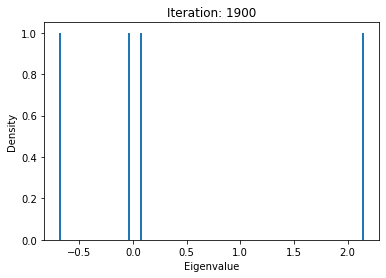

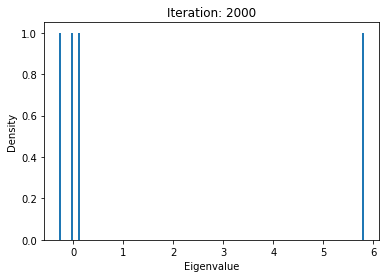

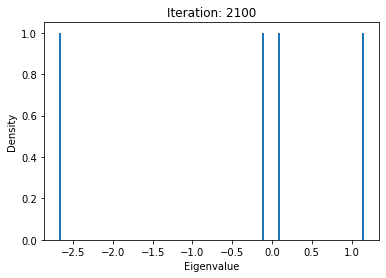

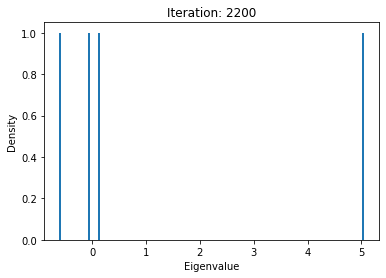

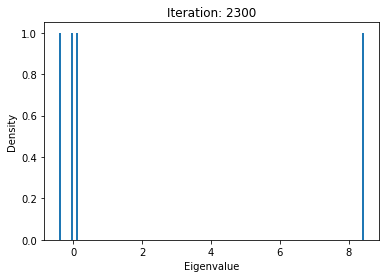

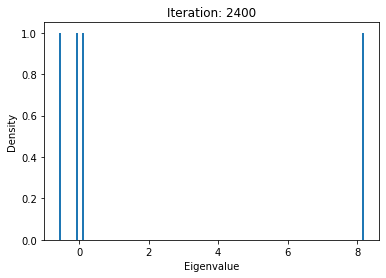

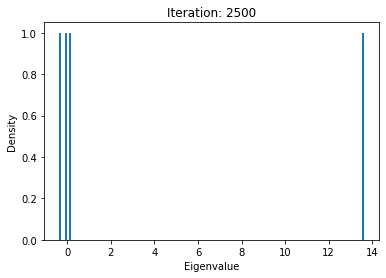

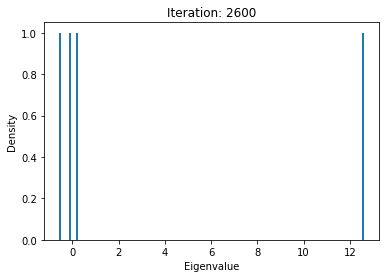

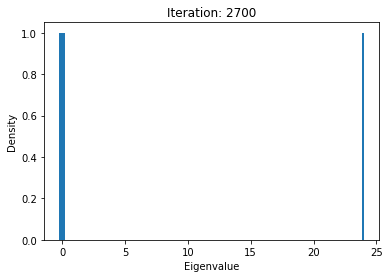

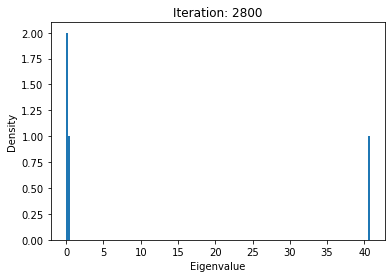

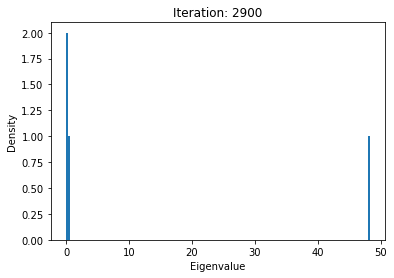

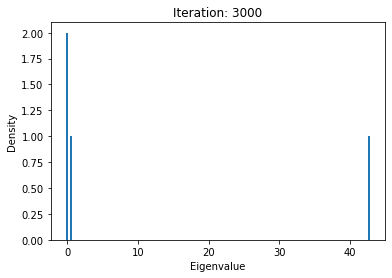

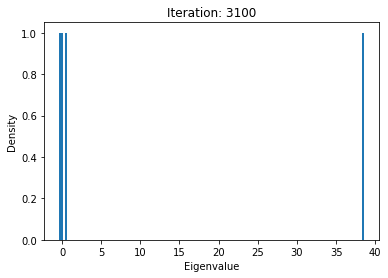

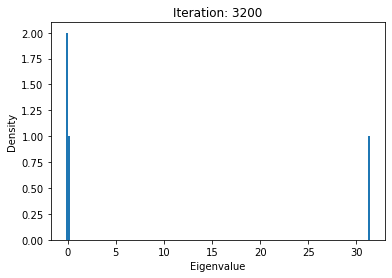

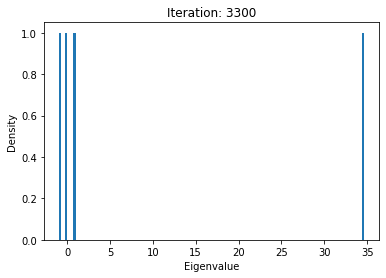

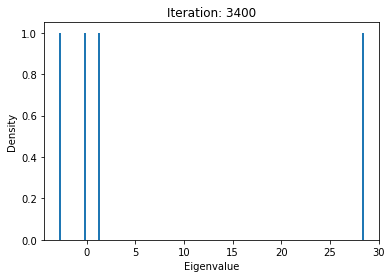

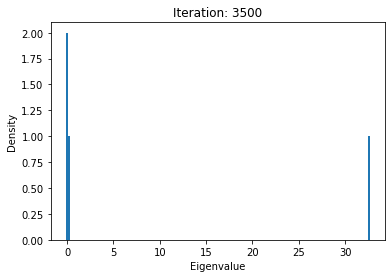

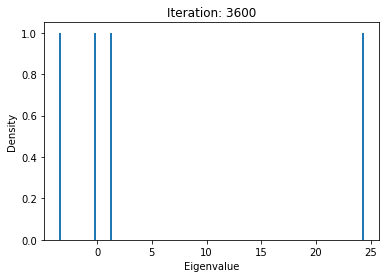

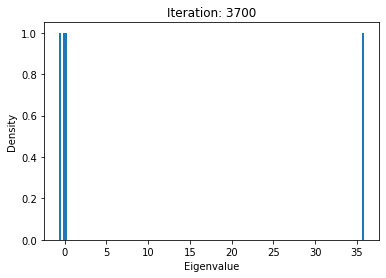

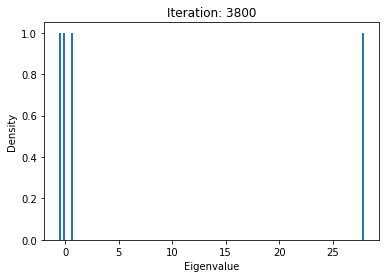

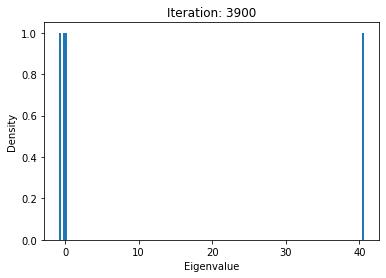

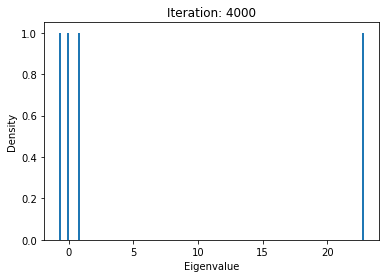

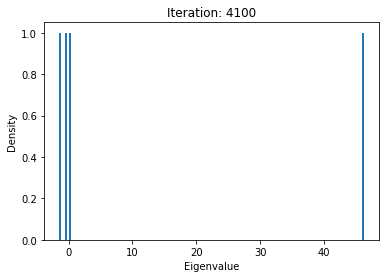

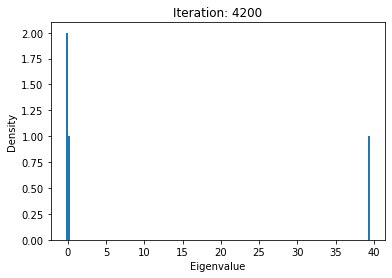

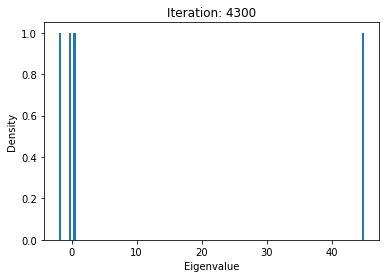

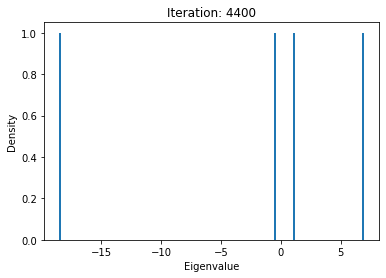

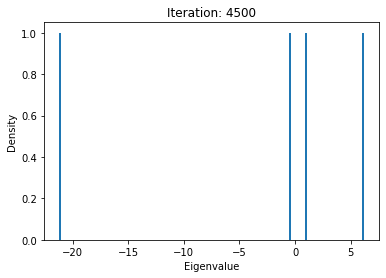

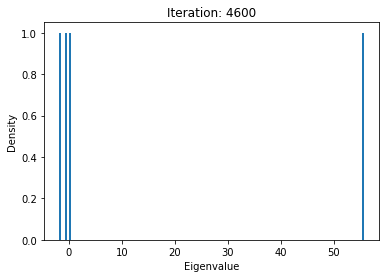

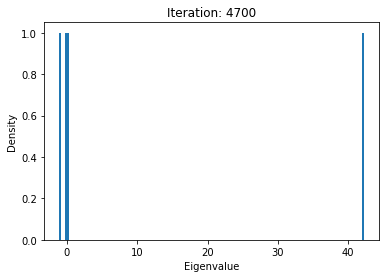

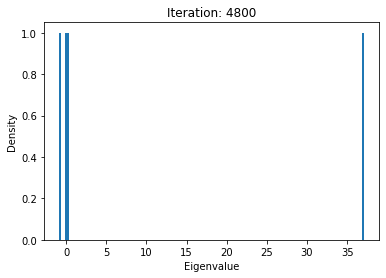

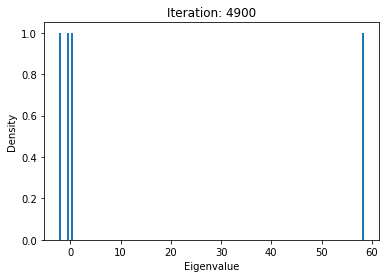

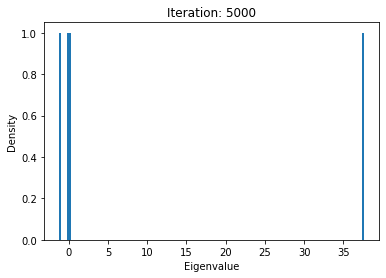

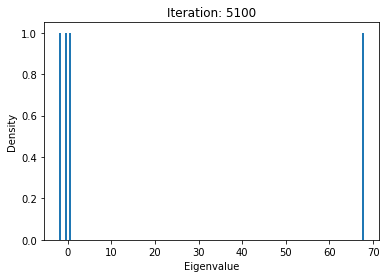

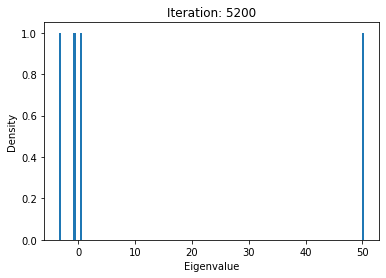

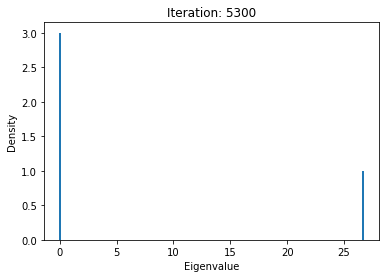

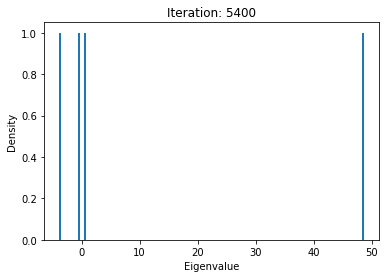

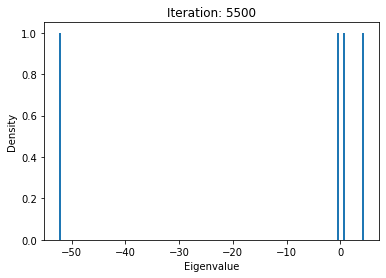

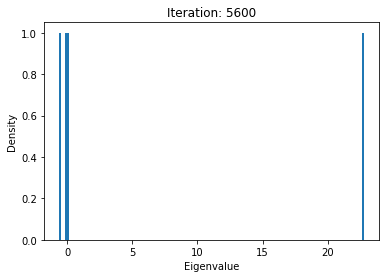

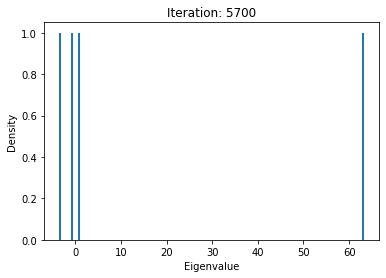

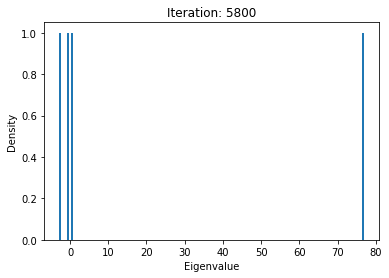

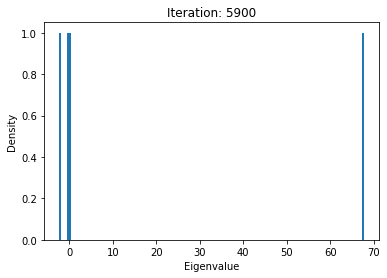

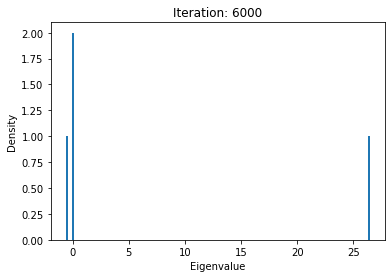

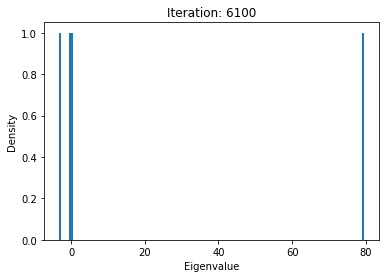

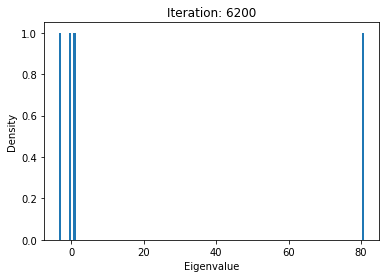

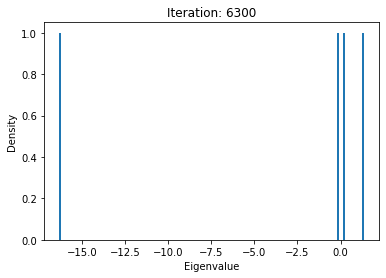

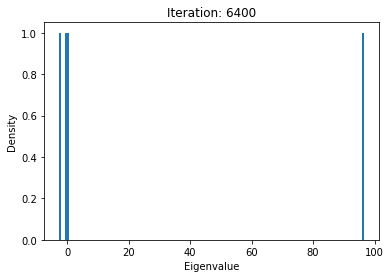

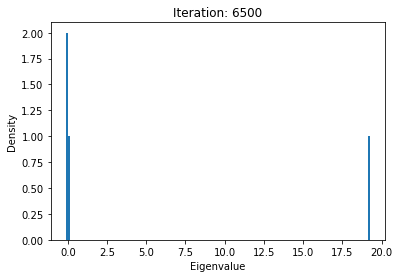

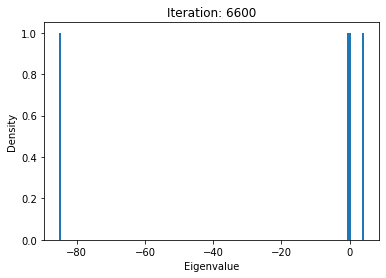

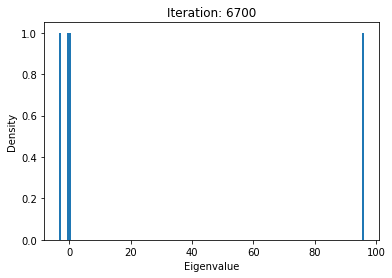

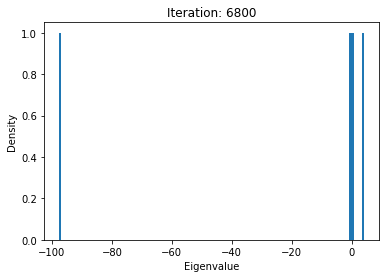

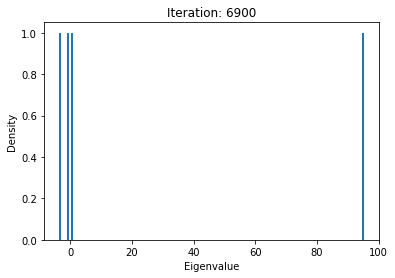

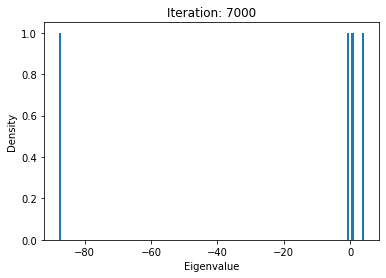

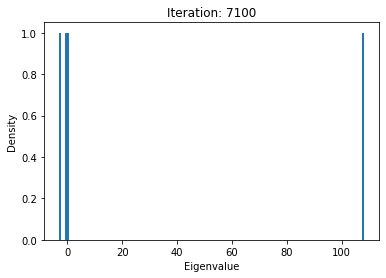

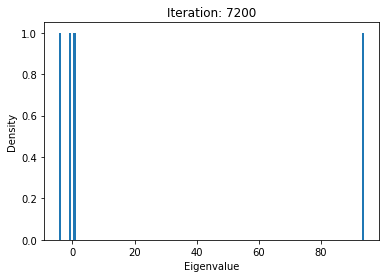

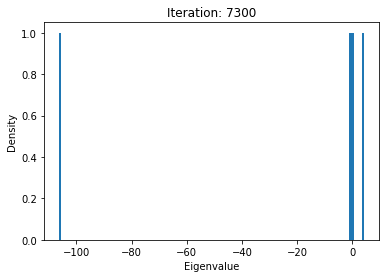

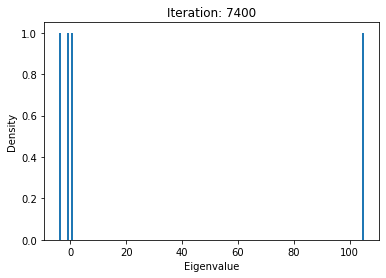

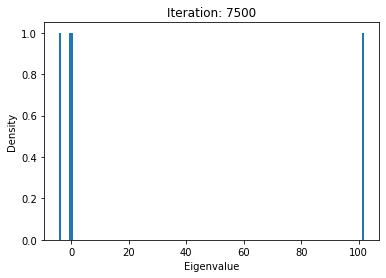

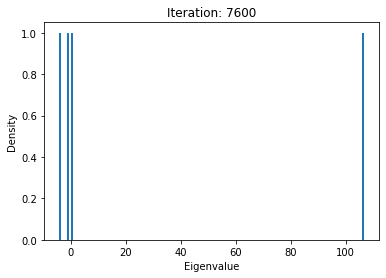

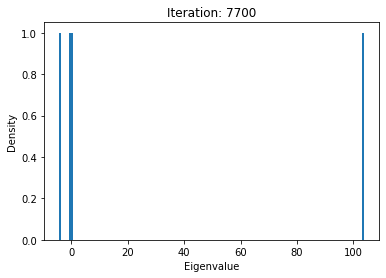

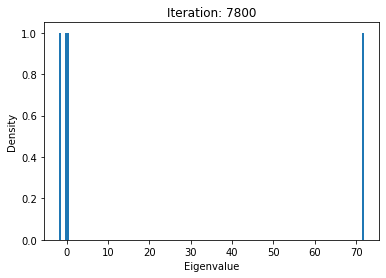

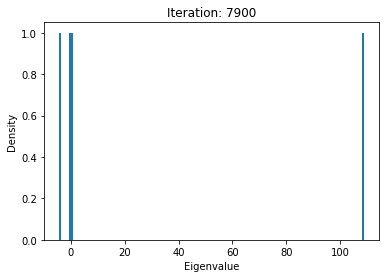

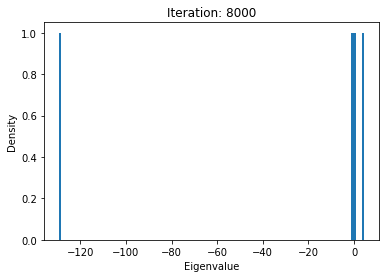

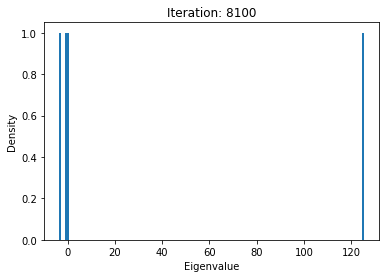

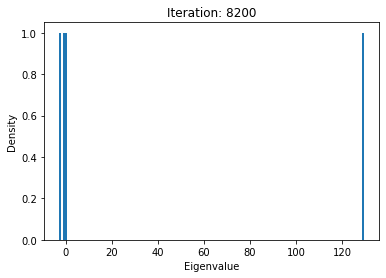

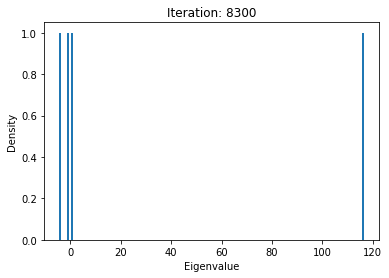

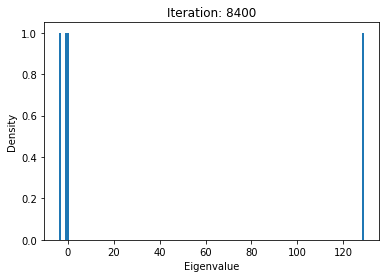

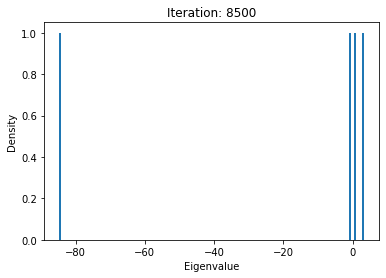

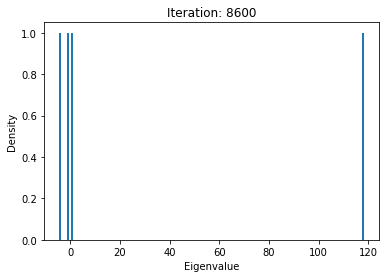

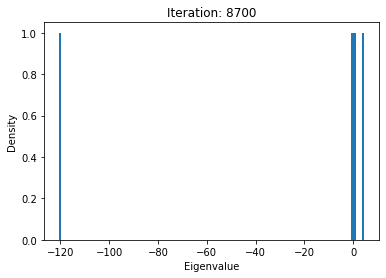

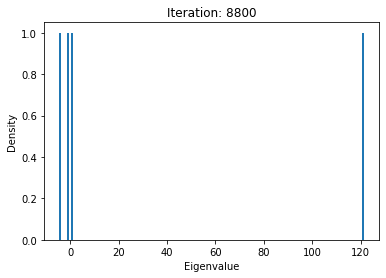

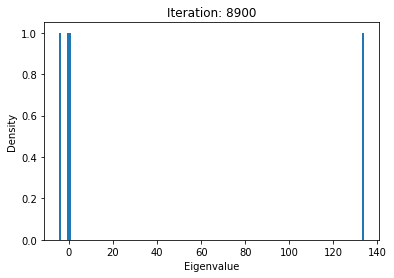

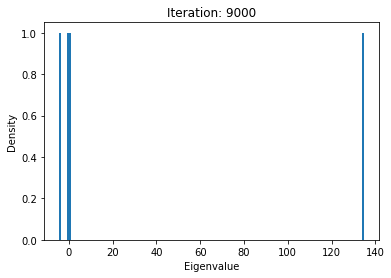

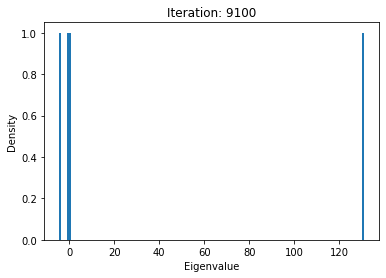

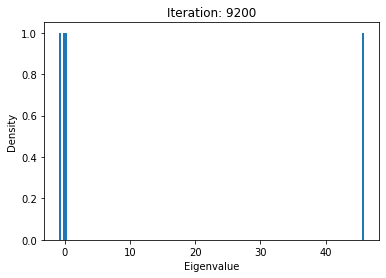

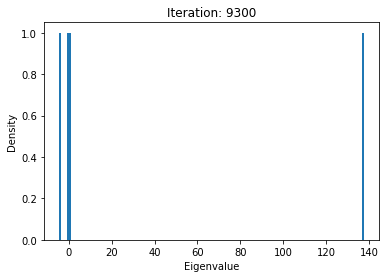

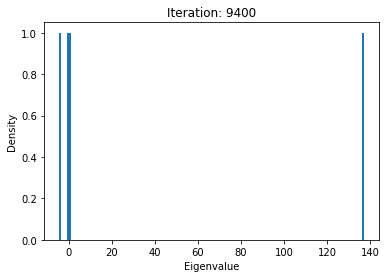

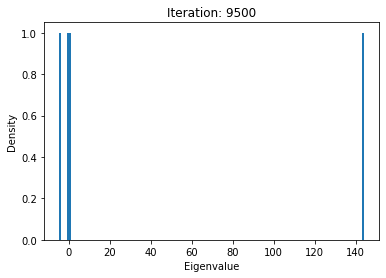

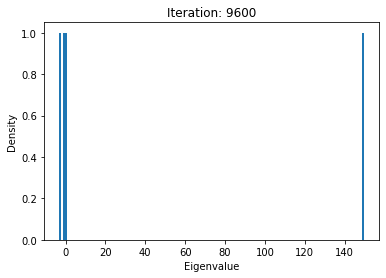

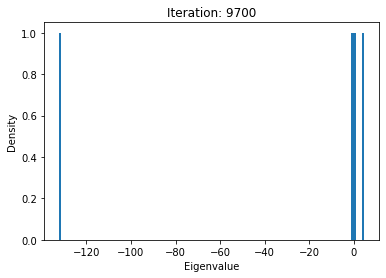

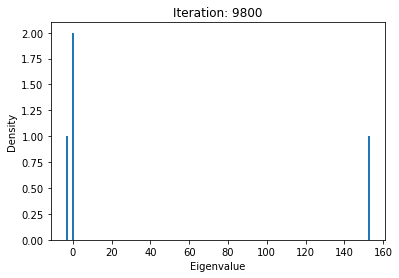

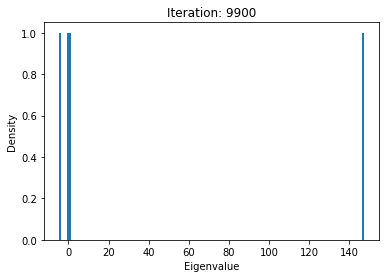

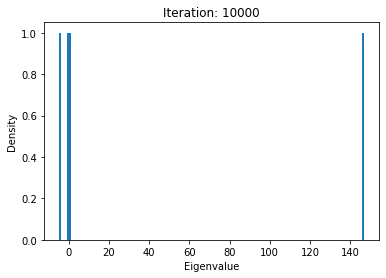

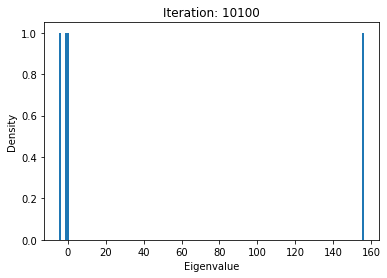

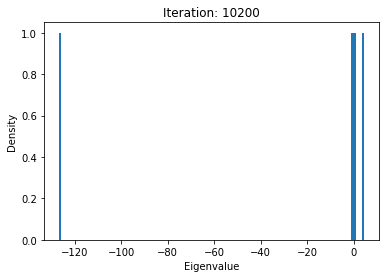

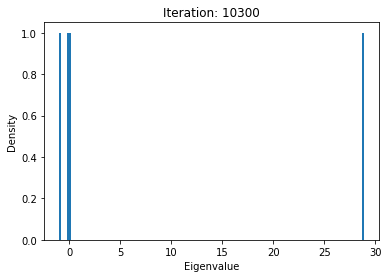

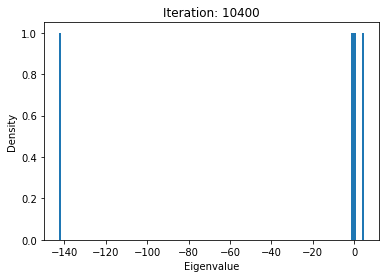

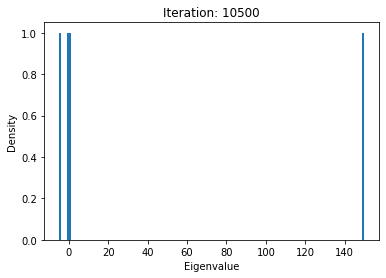

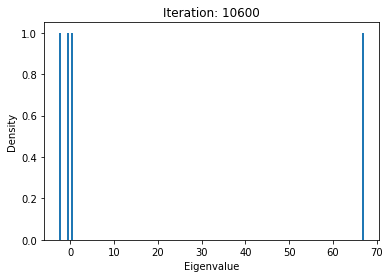

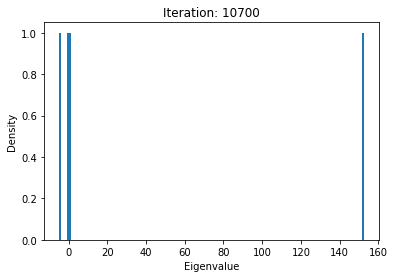

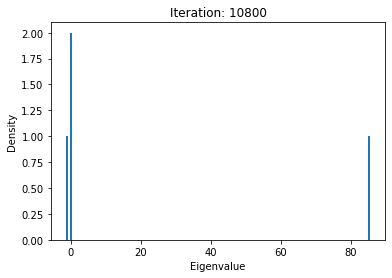

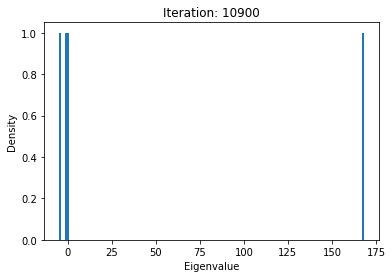

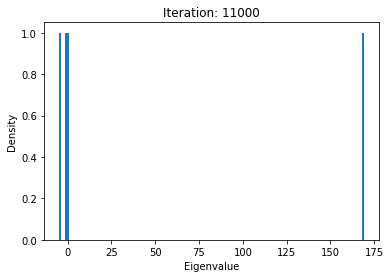

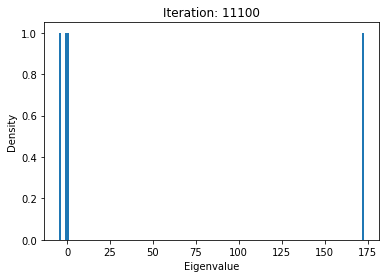

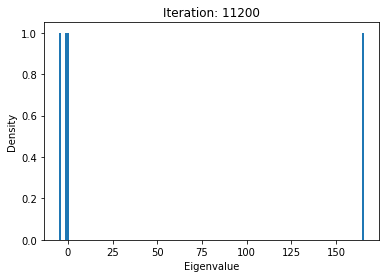

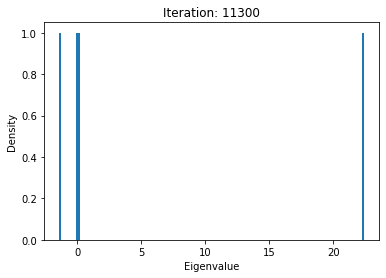

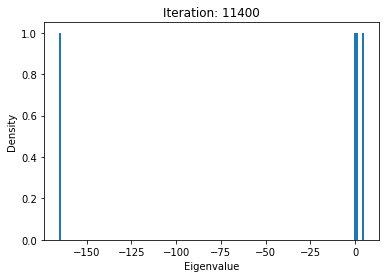

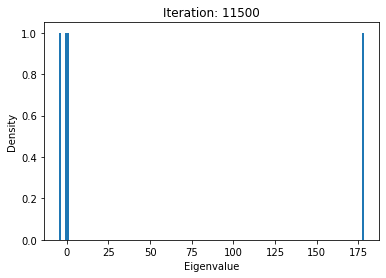

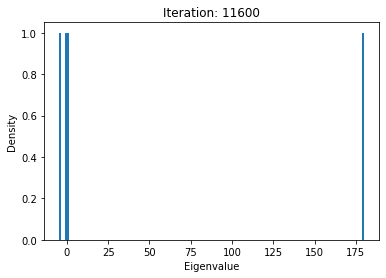

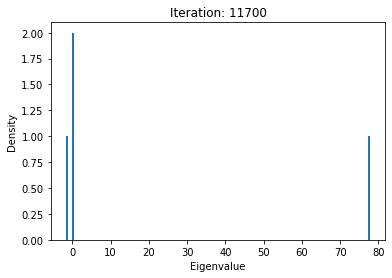

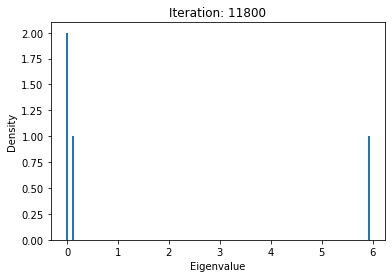

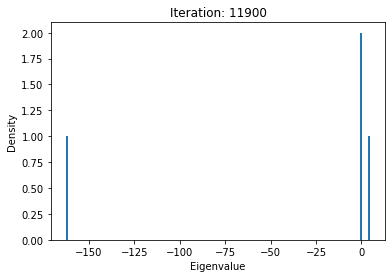

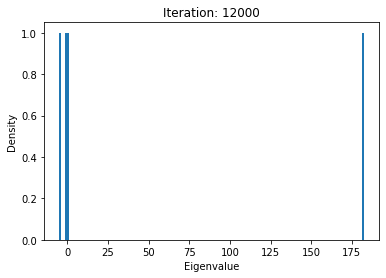

In [ ]:
#Create and save eigenvalue density plots.
library_hessian_data = torch.load('/content/drive/MyDrive/colab_notebooks/calculating_hessians/mofd_hessian/exponential_curve_with_mofd/experiment_3/library_hessian_data.pt')
for item in library_hessian_data:
  e, v = torch.symeig(item[3])
  plt.hist(e.cpu().numpy(), bins=150)
  plt.title("Iteration: " + str(item[0]))
  plt.xlabel('Eigenvalue')
  plt.ylabel('Density')
  plt.savefig('/content/drive/MyDrive/colab_notebooks/calculating_hessians/mofd_hessian/'
              + 'exponential_curve_with_mofd/experiment_3/eigenvalue_density_plots/eigenvalue_density_' 
              + str(item[0]) + '.png')
  plt.show()

In [ ]:
itr = 10200     #Iteration to examine.
model = torch.load('/content/drive/MyDrive/colab_notebooks/calculating_hessians/mofd_hessian'
                    + '/exponential_curve_with_mofd/experiment_3/models/model_' + str(itr) + '.pt')
model = model.to(device)

double_model = model.double()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
optimizer.zero_grad()

pred_y = odeint(double_model, true_y0.double(), t.double(), method=args.method).double()
base_loss = torch.mean(torch.abs(pred_y-true_y.double()))

shapes = []
for param in model.parameters():
  shapes.append(param.shape)

#Create vector of parameters.
param_tensors = double_model.parameters()
params_vec = torch.tensor([]).to(device)
for param in param_tensors:
  vec = torch.reshape(param, (-1,)).to(device)
  params_vec = torch.cat((params_vec, vec))

print('Getting Hessian with h = 1e-8')
mofd_hessian_8 = get_mofd_hessian(params_vec, shapes, base_loss, h=1e-8, show_iters=True)
print('')
print('Getting Hessian with h = 1e-7')
mofd_hessian_7 = get_mofd_hessian(params_vec, shapes, base_loss, h=1e-7, show_iters=True)
print('')
print('Getting Hessian with h = 1e-6')
mofd_hessian_6 = get_mofd_hessian(params_vec, shapes, base_loss, h=1e-6, show_iters=True)
print('')
print('Getting Hessian with h = 1e-5')
mofd_hessian_5 = get_mofd_hessian(params_vec, shapes, base_loss, h=1e-5, show_iters=True)
print('')
print('Getting Hessian with h = 1e-4')
mofd_hessian_4 = get_mofd_hessian(params_vec, shapes, base_loss, h=1e-4, show_iters=True)
print('')
print('Getting Hessian with h = 1e-3')
mofd_hessian_3 = get_mofd_hessian(params_vec, shapes, base_loss, h=1e-3, show_iters=True)
print('')
print('Getting Hessian with h = 1e-2')
mofd_hessian_2 = get_mofd_hessian(params_vec, shapes, base_loss, h=1e-2, show_iters=True)
print('')

model.to(torch.float32)

print('--------------------------------')
print('Obtaining manual hessian...')

pred_y = odeint(model, true_y0, t, method=args.method)
base_loss = torch.mean(torch.abs(pred_y-true_y))

grads = torch.autograd.grad(base_loss, model.parameters(), create_graph=True)
parameters = optimizer.param_groups[0]['params']

manual_hessian = get_manual_hessian(grads, parameters)           #get manual hessian.

for item in library_hessian_data:
  if item[0] == itr:
    library_hessian = item[3]                                    #get library hessian.

print('--------------------------------')
print('Library Hessian:')
print(library_hessian)
print('--------------------------------')
print('Manual Hessian:')
print(manual_hessian)
print('--------------------------------')
print('h = 1e-8')
print(mofd_hessian_8)
print('--------------------------------')
print('h = 1e-7')
print(mofd_hessian_7)
print('--------------------------------')
print('h = 1e-6')
print(mofd_hessian_6)
print('--------------------------------')
print('h = 1e-5')
print(mofd_hessian_5)
print('--------------------------------')
print('h = 1e-4')
print(mofd_hessian_4)
print('--------------------------------')
print('h = 1e-3')
print(mofd_hessian_3)
print('--------------------------------')
print('h = 1e-2')
print(mofd_hessian_2)

Getting Hessian with h = 1e-8
0 iterations remaining.
Getting Hessian with h = 1e-7
0 iterations remaining.
Getting Hessian with h = 1e-6
0 iterations remaining.
Getting Hessian with h = 1e-5
0 iterations remaining.
Getting Hessian with h = 1e-4
0 iterations remaining.
Getting Hessian with h = 1e-3
0 iterations remaining.
Getting Hessian with h = 1e-2
0 iterations remaining.
--------------------------------
Obtaining manual hessian...
Gradients calculated for row number 1.
Gradients calculated for row number 2.
Gradients calculated for row number 3.
Gradients calculated for row number 4.
Time used was  31.56967043876648
--------------------------------
Library Hessian:
tensor([[-120.3818,  -26.7455,   -5.5733,    4.9087],
        [ -26.7455,   -2.5220,   -2.7002,   -0.3573],
        [  -5.5733,   -2.7002,    0.2879,    0.3937],
        [   4.9087,   -0.3573,    0.3937,    0.1443]], device='cuda:0')
--------------------------------
Manual Hessian:
tensor([[-120.3818,  -26.7455,   -5.573

In [ ]:
e_m_8, v_m_8 = torch.symeig(mofd_hessian_8)
e_m_7, v_m_7 = torch.symeig(mofd_hessian_7)
e_m_6, v_m_6 = torch.symeig(mofd_hessian_6)
e_m_5, v_m_5 = torch.symeig(mofd_hessian_5)
e_m_4, v_m_4 = torch.symeig(mofd_hessian_4)
e_m_3, v_m_3 = torch.symeig(mofd_hessian_3)
e_m_2, v_m_2 = torch.symeig(mofd_hessian_2)

e_l, v_l = torch.symeig(library_hessian)
e_ma, v_ma = torch.symeig(manual_hessian)

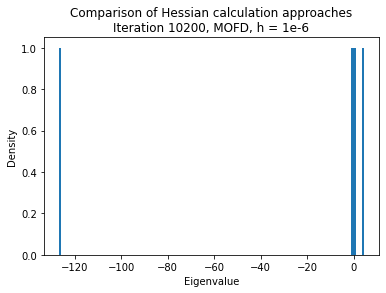

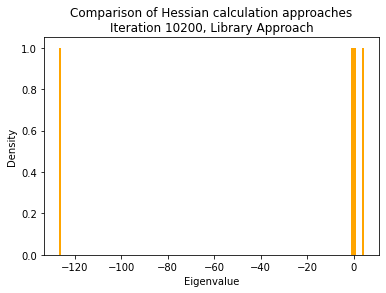

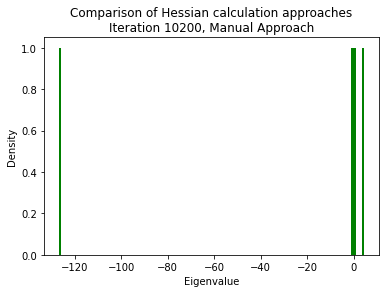

In [ ]:
plt.figure()

h = 6
plt.hist(e_m_6.cpu().detach().numpy(), bins=150, label = 'MOFD')
plt.title('Comparison of Hessian calculation approaches\nIteration ' + str(itr) + ', MOFD, h = 1e-' + str(h))
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.show()

plt.hist(e_l.cpu().detach().numpy(), bins=150, label = 'Library', color = 'Orange')
plt.title('Comparison of Hessian calculation approaches\nIteration ' + str(itr) + ', Library Approach')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.show()

plt.hist(e_ma.cpu().detach().numpy(), bins=150, label = 'Manual', color = 'Green')
plt.title('Comparison of Hessian calculation approaches\nIteration ' + str(itr) + ', Manual Approach')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(30, 8), facecolor='white')
ax_mofd = fig.add_subplot(131, frameon=False)
ax_lib = fig.add_subplot(132, frameon=False)
ax_man = fig.add_subplot(133, frameon=False)

ax_mofd.set_title('Iteration ' + str(itr) + '\nMOFD, h = 1e-' + str(h))
ax_mofd.set_xlabel('Eigenvalue')
ax_mofd.set_ylabel('Density')
ax_mofd.hist(e_m_7.cpu().detach().numpy(), bins=150, label = 'MOFD', color = 'Blue')

ax_lib.set_title('Iteration ' + str(itr) + '\nLibrary Approach')
ax_lib.set_xlabel('Eigenvalue')
ax_lib.set_ylabel('Density')
ax_lib.hist(e_l.cpu().detach().numpy(), bins=150, label = 'Library', color = 'Orange')

ax_man.set_title('Iteration ' + str(itr) + '\nManual Approach')
ax_man.set_xlabel('Eigenvalue')
ax_man.set_ylabel('Density')
ax_man.hist(e_ma.cpu().detach().numpy(), bins=150, label = 'Manual', color = 'Green')

plt.savefig('/content/drive/MyDrive/colab_notebooks/calculating_hessians/mofd_hessian'
              + '/exponential_curve_with_mofd/experiment_3/eigenvalue_density_comparisons'
              + '/iteration_' + str(itr) + '_h_' + str(h) + '.png')
plt.show()